In [6]:
import os
import numpy as np
import tensorflow as tf
from readers import reader
from google.protobuf import text_format
from protos import reader_pb2

tf.compat.v1.enable_eager_execution()

image_directory = '/own_files/yekeren/WSSGG/data-vspnet/images'
tf_record_file = '/own_files/yekeren/WSSGG/data-vspnet/tfrecords/caption-graph-hanwang/val.tfrecord-00000-of-00001'

options_str = r"""
  scene_graph_text_graph_reader {
    input_pattern: "%s"
    batch_size: 1
    shuffle_buffer_size: 10
    prefetch_buffer_size: 10
    feature_dimensions: 1536
  }
""" % (tf_record_file)

options = text_format.Merge(options_str, reader_pb2.Reader())
dataset = reader.get_input_fn(options, is_training=False)()
dataset_iter = dataset.__iter__()

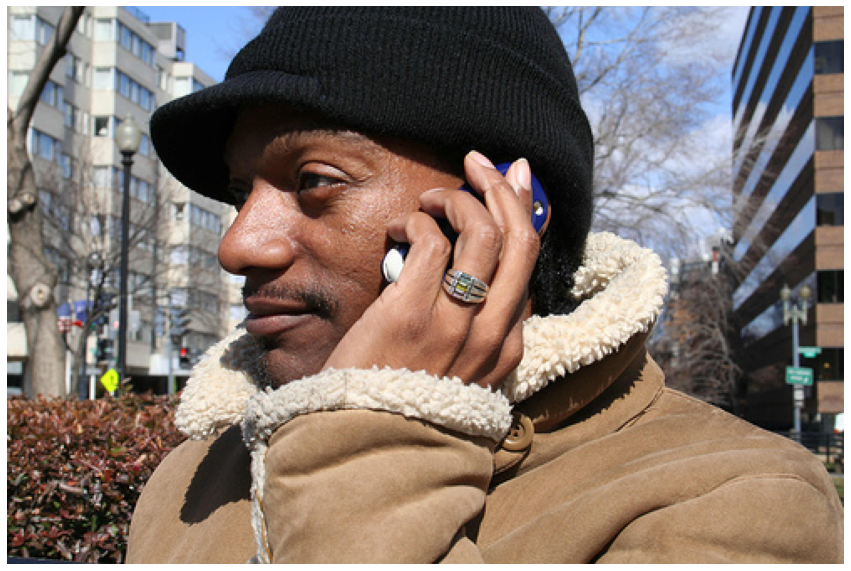

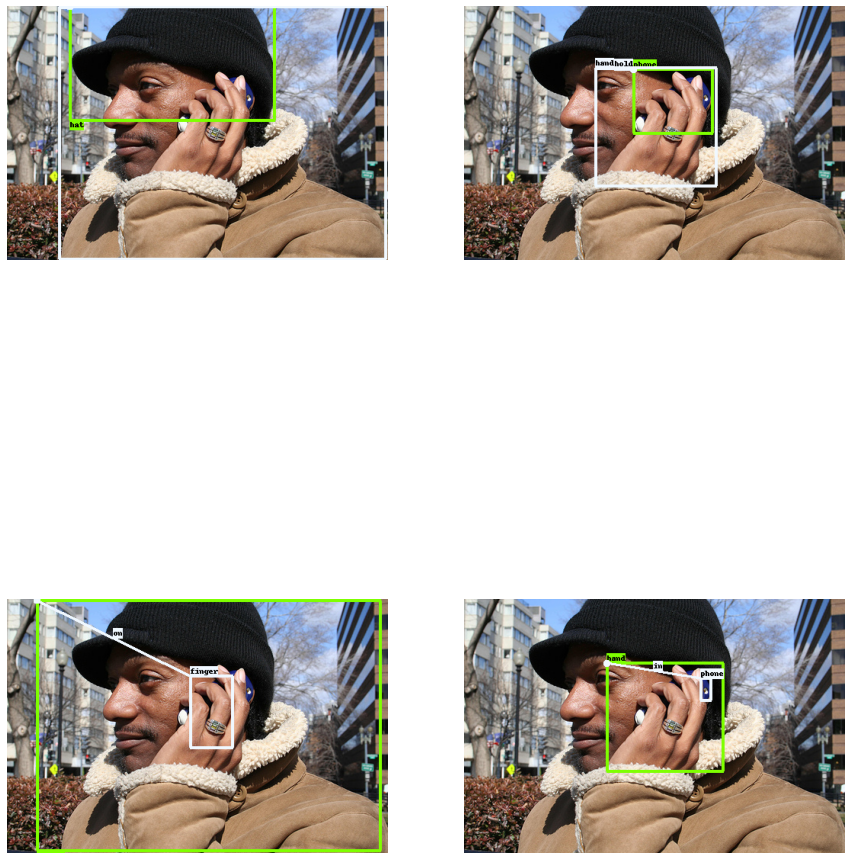

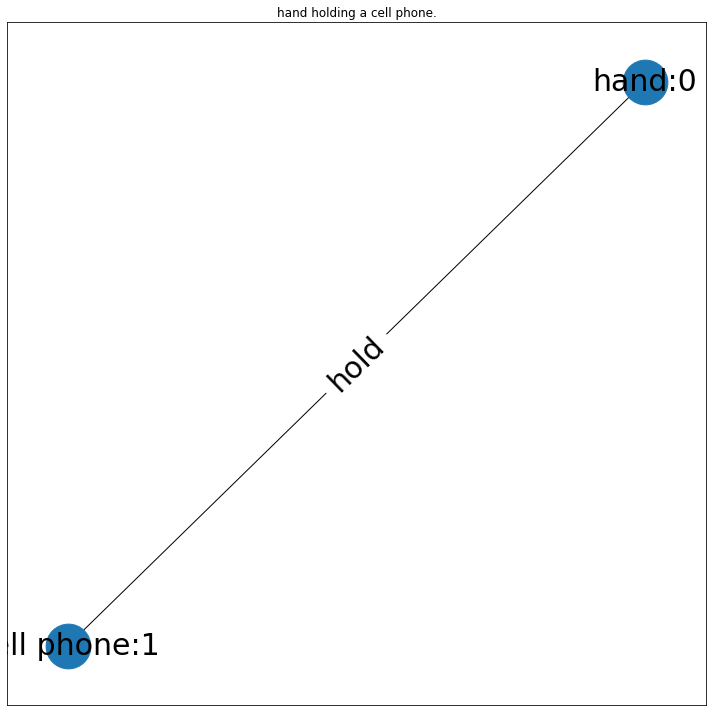

In [28]:
import matplotlib.pyplot as plt
import networkx as nx
import PIL.Image as Image
from modeling.utils import visualization

elem = next(dataset_iter)
image_id = elem['id'].numpy()[0]

# Show image.
image = Image.open(
    os.path.join(image_directory, '{}.jpg'.format(image_id)))
image = np.array(image)
plt.figure(figsize=(15, 20))
plt.imshow(image)
plt.axis('off')
plt.show()

# Show ground-truth triples.
plt.figure(figsize=(15, 20))
n_triple = elem['scene_graph/n_triple'].numpy()[0]
for i in range(min(n_triple, 4)):
  sub = elem['scene_graph/subject'].numpy()[0, i]
  obj = elem['scene_graph/object'].numpy()[0, i]
  pred = elem['scene_graph/predicate'].numpy()[0, i]

  sub_box = elem['scene_graph/subject/box'].numpy()[0, i]
  obj_box = elem['scene_graph/object/box'].numpy()[0, i]

  image_with_triple = visualization.draw_bounding_box_py_func_fn(
      image.copy(), 2, 
      [sub_box, obj_box], [sub, obj], None)
  image_with_triple = visualization.draw_arrow_py_func_fn(
      image_with_triple, 1, 
      [sub_box[0]], [sub_box[1]], [obj_box[0]],[obj_box[1]], [pred], None)

  plt.subplot(2, 2, i + 1)
  plt.imshow(image_with_triple)
  plt.axis('off')
    
# Show text graphs.
caption = elem['scene_text_graph/caption'].numpy()[0]
n_entity = elem['scene_text_graph/n_entity'].numpy()[0]
n_node = elem['scene_text_graph/n_node'].numpy()[0]
n_edge = elem['scene_text_graph/n_edge'].numpy()[0]
nodes = elem['scene_text_graph/nodes'].numpy()[0]
edges = elem['scene_text_graph/edges'].numpy()[0]
senders = elem['scene_text_graph/senders'].numpy()[0]
receivers = elem['scene_text_graph/receivers'].numpy()[0]

plt.figure(figsize=(10, 10))
plt.subplot(1, 1, 1).set_title(caption.decode('ascii'))

g = nx.DiGraph()
for sender, receiver, edge_label in zip(senders[:n_edge], receivers[:n_edge], edges[:n_edge]):
  edge_label = edge_label.decode('ascii')
  from_node = '%s:%i' % (nodes[sender].decode('ascii'), sender)
  to_node = '%s:%i' % (nodes[receiver].decode('ascii'), receiver)
  g.add_edge(from_node, to_node, label=edge_label, weight=0)

pos = nx.spring_layout(g, iterations=100)
nx.draw_networkx_nodes(g, pos, node_size=2000, node_shape='o')
nx.draw_networkx_labels(g, pos, font_size=30, font_family='sans-serif')
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_edge_labels(
    g, pos, font_size=30, edge_labels=dict([((u, v), d['label']) for u, v, d in g.edges(data=True)]))

        
plt.tight_layout()
plt.show()

